   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.2 MB/s eta 0:00:00


/tmp/ipython-input-1917635241.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("spamassassin/spam")
/tmp/ipython-input-1917635241.py:37: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("spamassassin/ham")


Размер датасета: (3002, 2)
label
0    2501
1     501
Name: count, dtype: int64

▶ Обучение GradientBoosting ...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       501
           1       1.00      0.81      0.90       100

    accuracy                           0.97       601
   macro avg       0.98      0.91      0.94       601
weighted avg       0.97      0.97      0.97       601


▶ Обучение AdaBoost ...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       501
           1       0.99      0.77      0.87       100

    accuracy                           0.96       601
   macro avg       0.97      0.88      0.92       601
weighted avg       0.96      0.96      0.96       601


▶ Обучение ExtraTrees ...
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       501
           1       0.97      0.90      0.93       100

    accuracy      

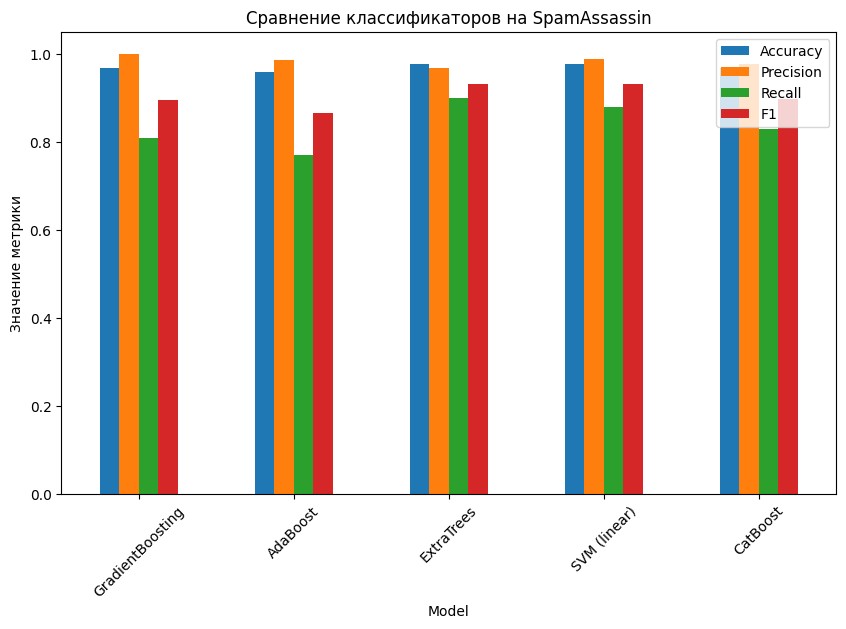

In [1]:
# Установка библиотек
!pip install catboost lightgbm xgboost

import os
import tarfile
import urllib.request
import email
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Классификаторы
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# --------------------------
# 1. Загрузка SpamAssassin
# --------------------------
url = "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2"
url_ham = "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2"

os.makedirs("spamassassin", exist_ok=True)

# Скачивание архивов
urllib.request.urlretrieve(url, "spamassassin/spam.tar.bz2")
urllib.request.urlretrieve(url_ham, "spamassassin/ham.tar.bz2")

# Распаковка
with tarfile.open("spamassassin/spam.tar.bz2") as tar:
    tar.extractall("spamassassin/spam")
with tarfile.open("spamassassin/ham.tar.bz2") as tar:
    tar.extractall("spamassassin/ham")

# --------------------------
# 2. Функция для чтения писем
# --------------------------
def load_emails_from_dir(path, label):
    emails = []
    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        if os.path.isfile(filepath):
            try:
                with open(filepath, "r", encoding="latin-1") as f:
                    msg = email.message_from_file(f)
                    content = ""
                    if msg.is_multipart():
                        for part in msg.walk():
                            if part.get_content_type() == "text/plain":
                                try:
                                    content += part.get_payload(decode=True).decode(errors="ignore")
                                except:
                                    pass
                    else:
                        try:
                            content = msg.get_payload(decode=True).decode(errors="ignore")
                        except:
                            pass
                    emails.append((content, label))
            except Exception as e:
                continue
    return emails

spam_emails = load_emails_from_dir("spamassassin/spam/spam", 1)
ham_emails = load_emails_from_dir("spamassassin/ham/easy_ham", 0)

data = spam_emails + ham_emails
df = pd.DataFrame(data, columns=["text", "label"])
print("Размер датасета:", df.shape)
print(df["label"].value_counts())

# --------------------------
# 3. Векторизация текста
# --------------------------
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df["text"].values)
y = df["label"].values

# --------------------------
# 4. Разделение на train/test
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# --------------------------
# 5. Обучение моделей
# --------------------------
models = {
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "SVM (linear)": SVC(kernel='linear', probability=True),
    "CatBoost": CatBoostClassifier(verbose=0)
}

results = []

for name, model in models.items():
    print(f"\n▶ Обучение {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])
    print(classification_report(y_test, y_pred))

# --------------------------
# 6. Сравнение моделей
# --------------------------
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\n📊 Итоговое сравнение:")
print(df_results)

# Визуализация
df_results.set_index("Model")[["Accuracy","Precision","Recall","F1"]].plot(kind="bar", figsize=(10,6))
plt.title("Сравнение классификаторов на SpamAssassin")
plt.ylabel("Значение метрики")
plt.xticks(rotation=45)
plt.show()
